# Optics simulation with tensor networks

## Setup

In [1]:
import discopy
discopy.__path__

['/home/mateusz/.local/lib/python3.10/site-packages/discopy']

In [2]:
import sys
sys.path.append('../..')

In [3]:
import numpy as np
import perceval as pcvl
import timeit
import optyx.zw as zw
import optyx.lo as circuit
from optyx import zx
import pandas as pd

In [4]:
import sympy as sp
from optyx import lo

#define a shallower ansatz (than the MZI ansatz)
#this will allow us to run wider circuits
#and have a more granular control over the overall circuit size
def ansatz_bs(width, depth):

    def p(i, j):
        return sp.Symbol(f"a_{i}_{j}")

    d = lo.Id(width)
    for i in range(depth):
        n_mzi = (width - 1) // 2 if i % 2 else width // 2
        left = lo.Id(i % 2)
        right = lo.Id(width - len(left.dom) - 2 * n_mzi)
        d >>= left.tensor(*[lo.BBS(p(i, j)) for j in range(n_mzi)]) @ right

    return d


# this function is used to convert a matrix to a linear optical circuit
def umatrix_to_perceval_circuit(matrix) -> pcvl.Circuit:
    _mzi_triangle = (
        pcvl.Circuit(2)
        // pcvl.BS()
        // (0, pcvl.PS(phi=pcvl.Parameter("phi_1")))
        // pcvl.BS()
        // (0, pcvl.PS(phi=pcvl.Parameter("phi_2")))
    )

    m = pcvl.Matrix(matrix.array.T)
    return pcvl.Circuit.decomposition(
        m,
        _mzi_triangle,
        phase_shifter_fn=pcvl.PS,
        shape="triangle",
        max_try=100
    ) 

In [5]:
def chip_mzi(w, l):
    ansatz = circuit.ansatz(w, l)
    symbs = list(ansatz.free_symbols)
    s = [(i, np.random.uniform(0, 1)) for i in symbs]
    return ansatz.subs(*s)

def chip_bbs(w, l):
    ansatz = ansatz_bs(w, l)
    symbs = list(ansatz.free_symbols)
    s = [(i, np.random.uniform(0, 1)) for i in symbs]
    return ansatz.subs(*s)

In [6]:
results_df = pd.DataFrame(columns=['experiment', 
                                   'mzi/bbs ansatz', 
                                   'width', 
                                   'depth', 
                                   'optyx_time', 
                                   'perceval_time', 
                                   'n_runs'])

In [7]:
#unfortunately, the outputs from Perceval and Optyx are not in the same order
#define a utility function to check if the output is the same
def ensure_lists_have_same_elements(list1, list2):
    list1 = np.round(list1, 4)
    list2 = np.round(list2, 4)
    #remove 0 elements
    list1 = list1[np.where(list1 > 0)]
    list2 = list2[np.where(list2 > 0)]

    if len(list1) != len(list2):
        return False
    for i in list1:
        found_match = False
        for j in list2:
            if np.allclose(i, j):
                found_match = True
                break
        if not found_match:
            return False   
    return True

In [8]:
import networkx as nx

def generate_networkx_linear_graph(n_vertices):
    G = nx.Graph()
    for i in range(n_vertices):
        G.add_node(i)
        if i != 0:
            G.add_edge(i, i-1)
    return G

def generate_zx_linear_cluster_state(n_parties):
    diagram = zx.Z(0, 1)
    for i in range(1, n_parties):
        layer = zx.Id(0)
        for j in range(1, i):
            layer = layer @ zx.Id(1)
        layer = layer @ (zx.Z(1, 2) >> (zx.Id(1) @ zx.H))
        diagram = diagram >> layer
    return diagram

def bps_input_state(w):
    input_state = [1] * w
    pcvl_input_state = pcvl.BasicState(input_state)
    zw_input_state = zw.Create(*input_state)
    return pcvl_input_state, zw_input_state

def ghz_input_state(w):
    n_parties = int(w/2)
    zw_input_state = zx.zx2path(zx.decomp(zx.Z(0, n_parties))).to_zw()
    pcvl_input_state = pcvl.StateGenerator(pcvl.Encoding.DUAL_RAIL).ghz_state(n_parties)
    return pcvl_input_state, zw_input_state

def linear_cluster_state(w):
    n_parties = int(w/2)
    zw_input_state = zx.zx2path(zx.decomp(generate_zx_linear_cluster_state(n_parties))).to_zw()
    pcvl_input_state = pcvl.StateGenerator(pcvl.Encoding.DUAL_RAIL).graph_state(generate_networkx_linear_graph(n_parties))
    return pcvl_input_state, zw_input_state

In [9]:
def run_experiment(benchmark_circuits, 
                   input_state_f, 
                   n_runs, 
                   ansatz_type, 
                   experiment_name,
                   entangled=False):
    
    results = pd.DataFrame(columns=['experiment', 
                                    'mzi/bbs ansatz', 
                                    'width', 
                                    'depth', 
                                    'optyx_time', 
                                    'perceval_time', 
                                    'n_runs'])
    
    for U, w, l in benchmark_circuits:

        max_dim = w + 1

        if entangled:
            max_dim = int(np.floor(w/2))+1

        U_matrix = U.to_path()
        
        # 1. FIRST CHECK IF THE RESULTS AGREE

        #generate input state
        pcvl_input_state, optyx_input_state = input_state_f(w)

        #calculate probability using Perceval
        perceval_circuit = umatrix_to_perceval_circuit(U_matrix)
        backend = pcvl.BackendFactory.get_backend("SLOS")
        sim = pcvl.Simulator(backend)
        sim.set_circuit(perceval_circuit)
        pcvl_prob = sim.probs(pcvl_input_state)
        pcvl_prob = list(pcvl_prob.values())

        #calculate probability using Optyx with tensor contraction
        zw_circuit = optyx_input_state >> U.to_zw()
        tensor = zw_circuit.to_tensor(max_dim=max_dim)
        quimb_tensor = tensor.to_quimb()
        zw_prob = np.abs((quimb_tensor ^ ...).data)**2

        if entangled:
            zw_prob = zw_prob/2

        zw_prob = zw_prob[np.nonzero(np.round(zw_prob, 6))]

        #check that the probabilities agree
        assert ensure_lists_have_same_elements(pcvl_prob, zw_prob)

        # 2. RUN THE BENCHMARK
        
        local_namespace = {
            'quimb_tensor': quimb_tensor
        }

        time_optyx = timeit.timeit('quimb_tensor ^ ...', number=n_runs, globals=local_namespace)

        local_namespace = {
            'sim': sim,
            'pcvl_input_state': pcvl_input_state,
        }

        time_perceval = timeit.timeit('sim.probs(pcvl_input_state)', number=n_runs, globals=local_namespace)

        result = {
            'experiment': experiment_name,
            'mzi/bbs ansatz': ansatz_type,
            'depth': l,
            'optyx_time': time_optyx,
            'perceval_time': time_perceval,
            'n_runs': n_runs,
            'width': w,
        }

        results = pd.concat([results, pd.DataFrame([result])], ignore_index=True)

    return results

## Run the experiments

In [10]:
number_of_runs = 5

In [11]:
max_width = 13

benchmark_circuits_mzi = [(chip_mzi(x, y), x, y) for x in range(1, max_width) for y in range(1, int(np.ceil((max_width-x)/2)+1))]
benchmark_circuits_bbs = [(chip_bbs(x, y), x, y) for x in range(1, max_width) for y in range(1, int(np.ceil((max_width-x)/2)+1))]

### A bosonic product state as an input

In [12]:
results_df = pd.concat([results_df, run_experiment(benchmark_circuits_mzi, 
                                                   bps_input_state, 
                                                   number_of_runs, 
                                                   'mzi',
                                                   'Bosonic product state')])


/tmp/ipykernel_99348/1899573335.py:73: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([result])], ignore_index=True)
/tmp/ipykernel_99348/3773231207.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, run_experiment(benchmark_circuits_mzi,


In [13]:
results_df = pd.concat([results_df, run_experiment(benchmark_circuits_bbs, 
                                                   bps_input_state, 
                                                   number_of_runs, 'bbs',
                                                   'Bosonic product state')])

/tmp/ipykernel_99348/1899573335.py:73: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([result])], ignore_index=True)


### Entangled GHZ state as an input

In [14]:
max_width = 14

benchmark_circuits_mzi = [(chip_mzi(x, y), x, y) for x in range(6, max_width, 2) for y in range(1, int(np.ceil((max_width-x)/2)+1), 2)]
benchmark_circuits_bbs = [(chip_bbs(x, y), x, y) for x in range(6, max_width, 2) for y in range(1, int(np.ceil((max_width-x)/2)+1), 2)]

In [15]:
results_df = pd.concat([results_df, run_experiment(benchmark_circuits_mzi, 
                                                   ghz_input_state, 
                                                   number_of_runs, 
                                                   'mzi',
                                                   'GHZ', True)])

/tmp/ipykernel_99348/1899573335.py:73: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([result])], ignore_index=True)


In [16]:
results_df = pd.concat([results_df, run_experiment(benchmark_circuits_bbs, 
                                                   ghz_input_state, 
                                                   number_of_runs, 'bbs',
                                                   'GHZ', True)])

/tmp/ipykernel_99348/1899573335.py:73: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([result])], ignore_index=True)


### Linear cluster state

In [72]:
max_width
[( x, y) for x in range(2, 17, 2) for y in range(1, int(np.ceil((17-x)/3)+1), 1)]

[(2, 1),
 (2, 2),
 (2, 3),
 (2, 4),
 (2, 5),
 (4, 1),
 (4, 2),
 (4, 3),
 (4, 4),
 (4, 5),
 (6, 1),
 (6, 2),
 (6, 3),
 (6, 4),
 (8, 1),
 (8, 2),
 (8, 3),
 (10, 1),
 (10, 2),
 (10, 3),
 (12, 1),
 (12, 2),
 (14, 1),
 (16, 1)]

In [17]:
max_width = 15

benchmark_circuits_mzi = [(chip_mzi(x, y), x, y) for x in range(2, max_width, 2) for y in range(1, int(np.ceil((max_width-x)/3)+1), 1)]

max_width = 15

benchmark_circuits_bbs = [(chip_bbs(x, y), x, y) for x in range(2, max_width, 2) for y in range(1, int(np.ceil((max_width-x)/3)+1), 1)]

In [18]:
results_df = pd.concat([results_df, run_experiment(benchmark_circuits_mzi, 
                                                   linear_cluster_state, 
                                                   number_of_runs, 
                                                   'mzi',
                                                   'Linear cluster state', True)])


/tmp/ipykernel_99348/1899573335.py:73: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([result])], ignore_index=True)


In [19]:
results_df = pd.concat([results_df, run_experiment(benchmark_circuits_bbs, 
                                                   linear_cluster_state, 
                                                   number_of_runs, 'bbs',
                                                   'Linear cluster state', True)])

/tmp/ipykernel_99348/1899573335.py:73: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([result])], ignore_index=True)


In [20]:
## Save the results to a CSV file
results_df.to_csv('optyx_vs_perceval.csv')

## Plot the results

In [21]:
import seaborn as sns

In [65]:
results_df["optyx/perceval"] = results_df["optyx_time"] / results_df["perceval_time"]

melted_df = results_df.melt(
    id_vars=['experiment', 'mzi/bbs ansatz', 'width', 'depth', 'n_runs'], 
    value_vars=['optyx_time', 'perceval_time'], 
    var_name='framework', 
    value_name='time'
)

melted_df['framework'] = melted_df['framework'].map({'optyx_time': 'optyx', 'perceval_time': 'perceval'})

In [66]:
melted_df["time"] = melted_df["time"] / melted_df["n_runs"]

In [24]:
sns.set_theme()

import matplotlib.pyplot as plt


In [55]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def plot(experiment, ansatz, title, depth=None):

    if depth is None:
        depths = melted_df.query(f"experiment == '{experiment}' and `mzi/bbs ansatz` == '{ansatz}'")['depth'].unique()
        alpha_map = {depth: np.interp(depth, (min(depths), max(depths)), (1.0, 0.1)) for depth in depths}
    else:
        depths = [depth]
        alpha_map = {depth: 1.0}
    marker_map = {"optyx": "o", "perceval": "s"} 
    color_map = {"optyx": "blue", "perceval": "orange"} 

    plt.figure(figsize=(10, 6))
    for depth_ in depths:
        subset = melted_df.query(f"experiment == '{experiment}' and `mzi/bbs ansatz` == '{ansatz}' and depth == @depth_")
        for framework in subset['framework'].unique():
            framework_subset = subset[subset['framework'] == framework]
            sns.lineplot(
                data=framework_subset, 
                x="width", 
                y="time", 
                label=None, 
                alpha=alpha_map[depth_],
                marker=marker_map[framework], 
                color=color_map[framework],
                linewidth=1.5,
            )

    framework_legend = [
        Line2D([0], [0], color="blue", marker="o", markersize=8, lw=2, label="optyx"),
        Line2D([0], [0], color="orange", marker="s", markersize=8, lw=2, label="perceval")
    ]

    if depth is None:
        depth_legend = [
            Line2D([0], [0], color="black", lw=2, alpha=alpha_map[depth], label=f"Depth {depth}") for depth in sorted(depths)
        ]

    if depth is not None:
        plt.legend(handles=framework_legend, title="Framework", loc="upper left", bbox_to_anchor=(1.05, 1))
    else:
        plt.legend(handles=framework_legend + depth_legend, title="Framework and Depth", loc="upper left", bbox_to_anchor=(1.05, 1))
    plt.title(title)
    plt.xlabel("Width")
    plt.ylabel("Time")
    plt.tight_layout()
    plt.show()


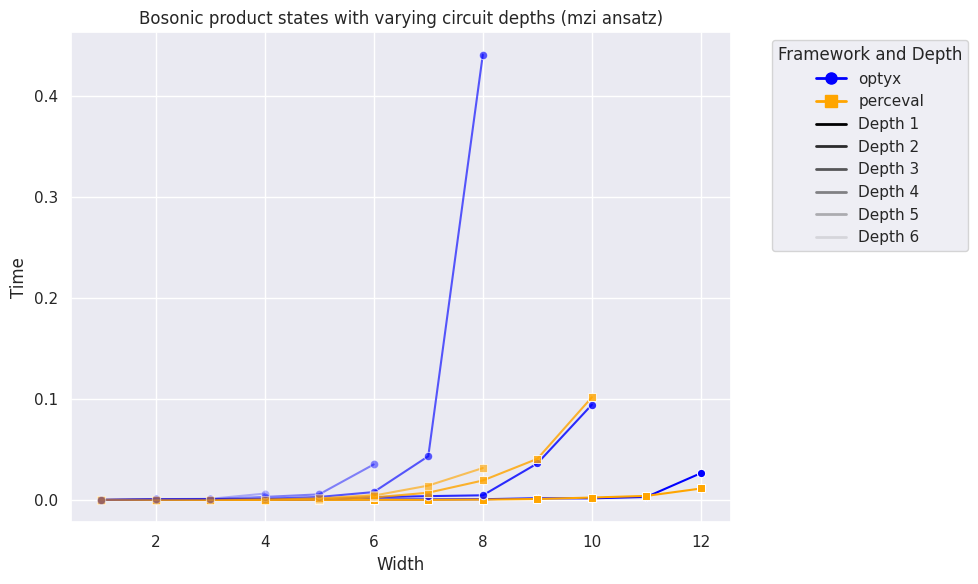

In [56]:
plot("Bosonic product state", "mzi", "Bosonic product states with varying circuit depths (mzi ansatz)")

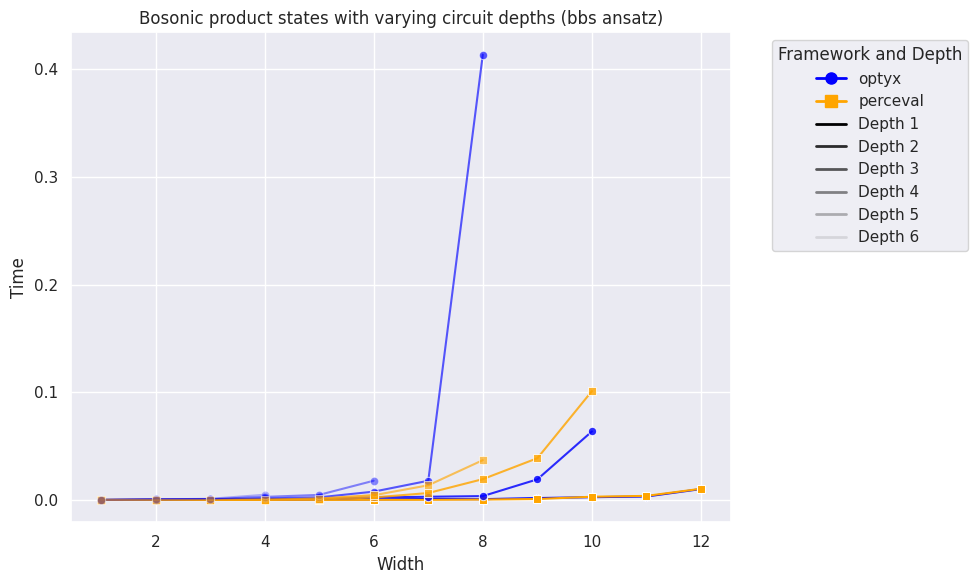

In [57]:
plot("Bosonic product state", "bbs", "Bosonic product states with varying circuit depths (bbs ansatz)")

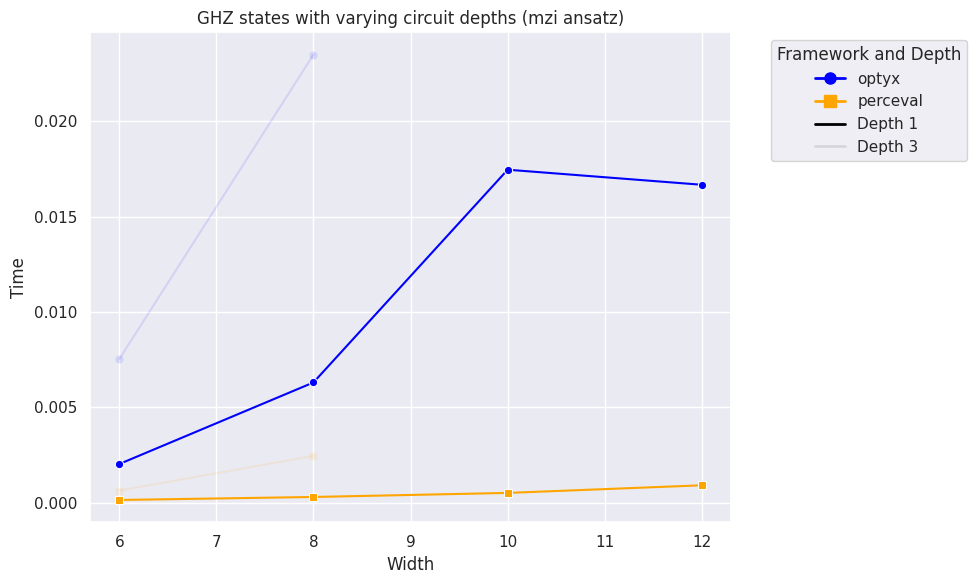

In [58]:
plot("GHZ", "mzi", "GHZ states with varying circuit depths (mzi ansatz)")

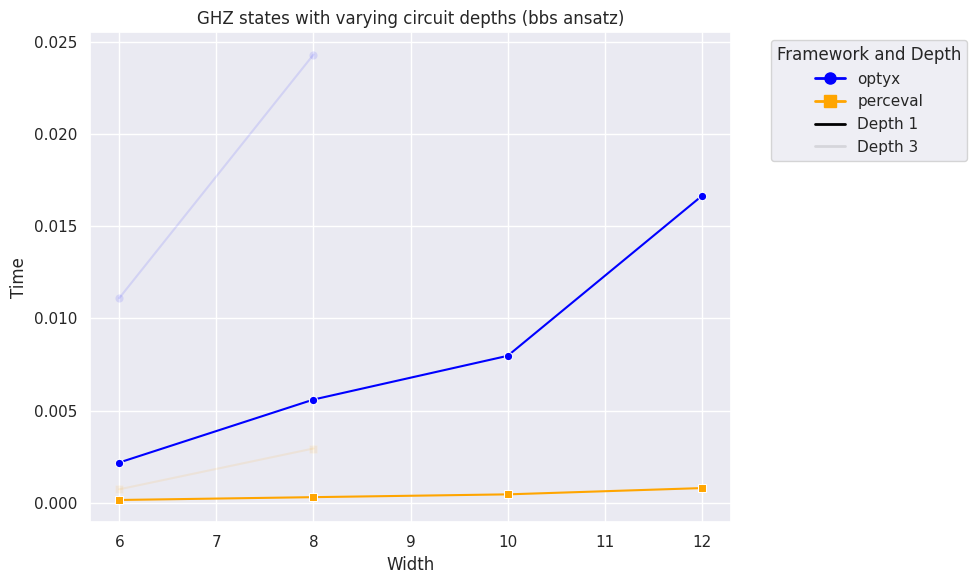

In [59]:
plot("GHZ", "bbs", "GHZ states with varying circuit depths (bbs ansatz)")

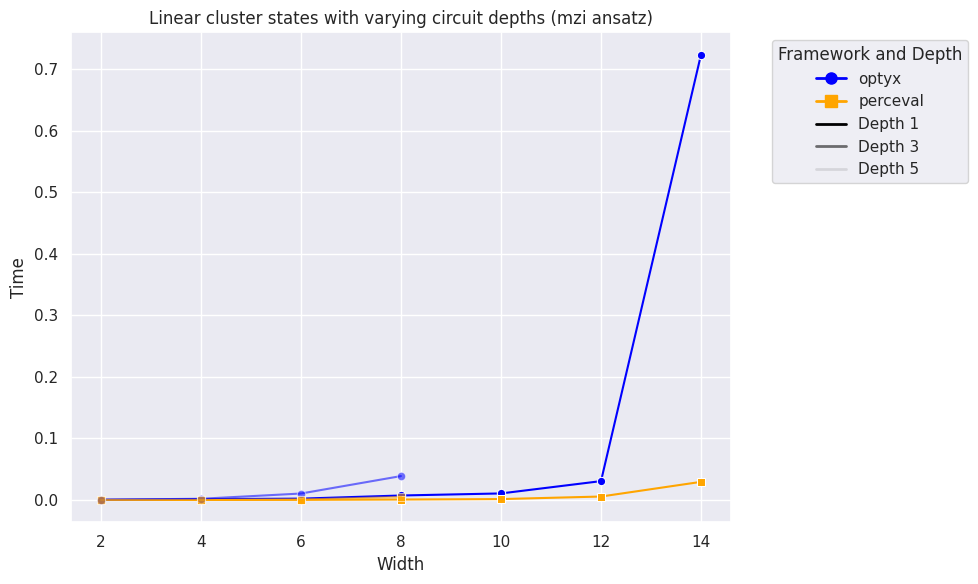

In [60]:
plot("Linear cluster state", "mzi", "Linear cluster states with varying circuit depths (mzi ansatz)")

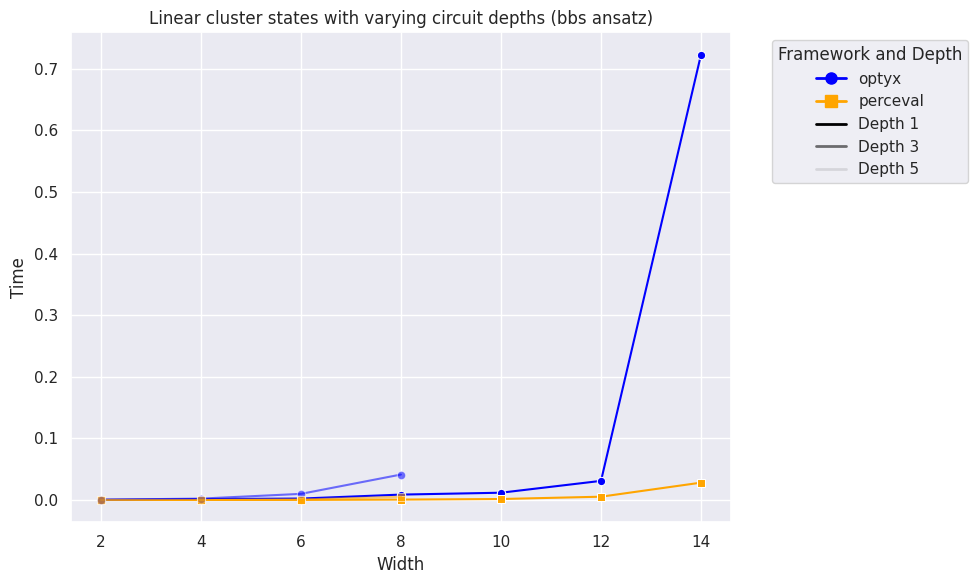

In [61]:
plot("Linear cluster state", "bbs", "Linear cluster states with varying circuit depths (bbs ansatz)")

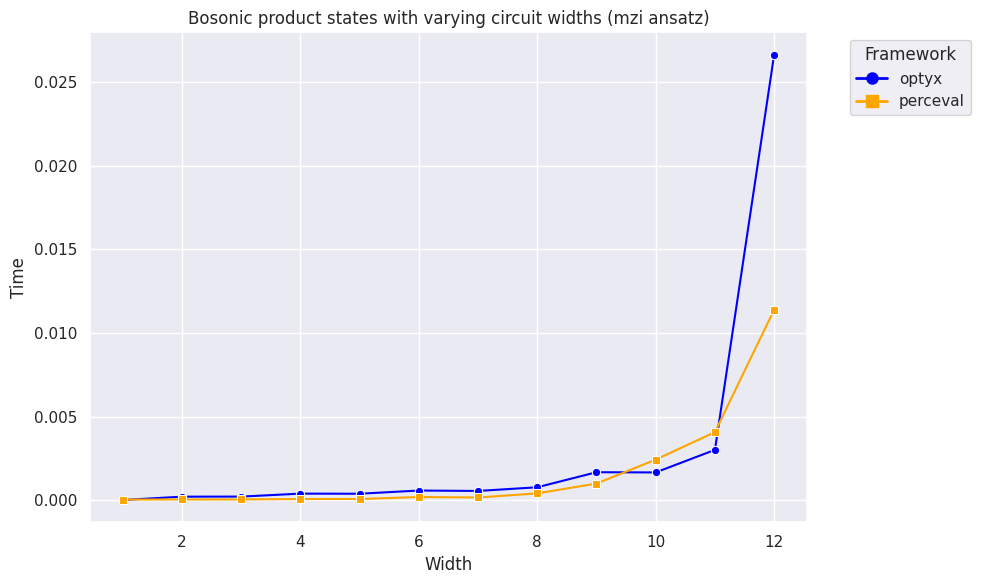

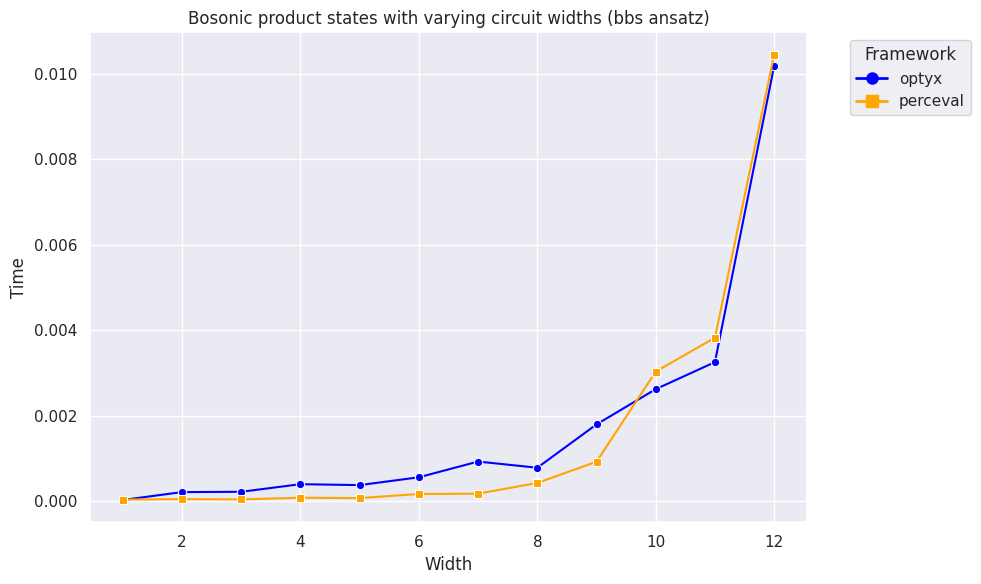

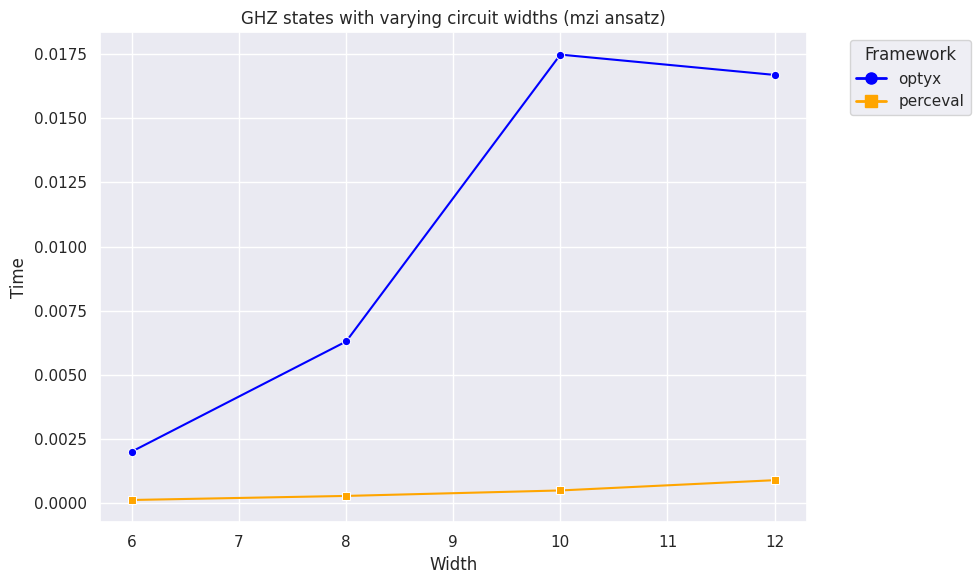

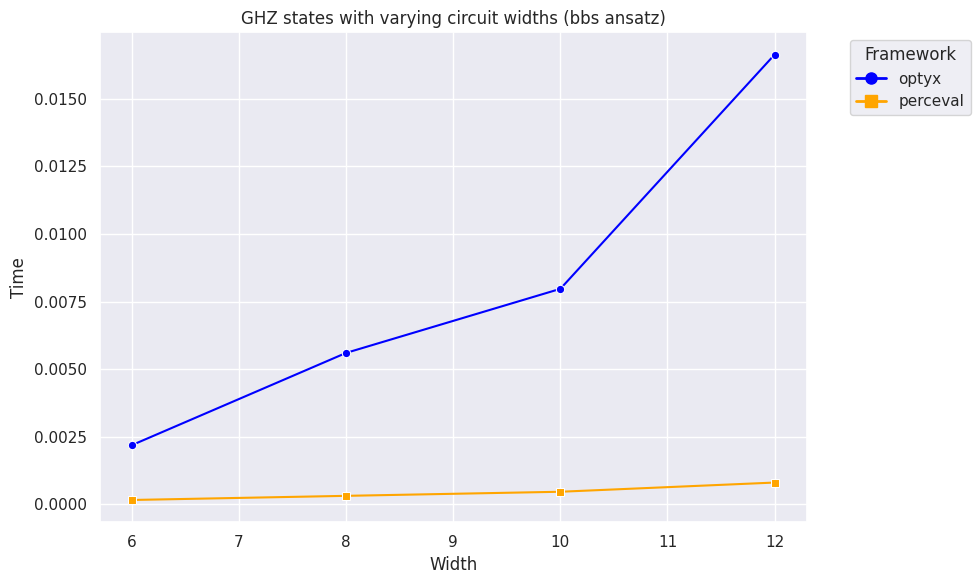

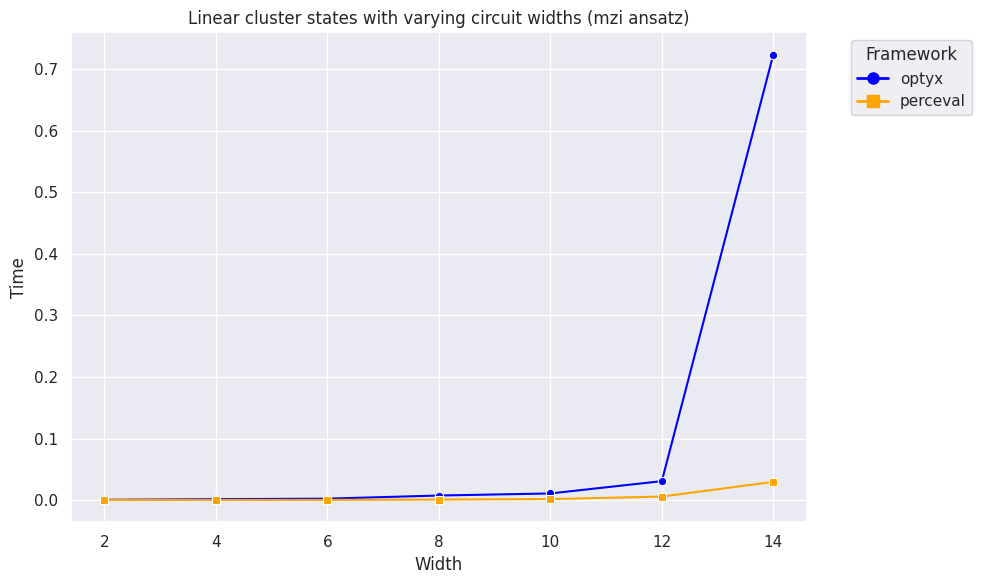

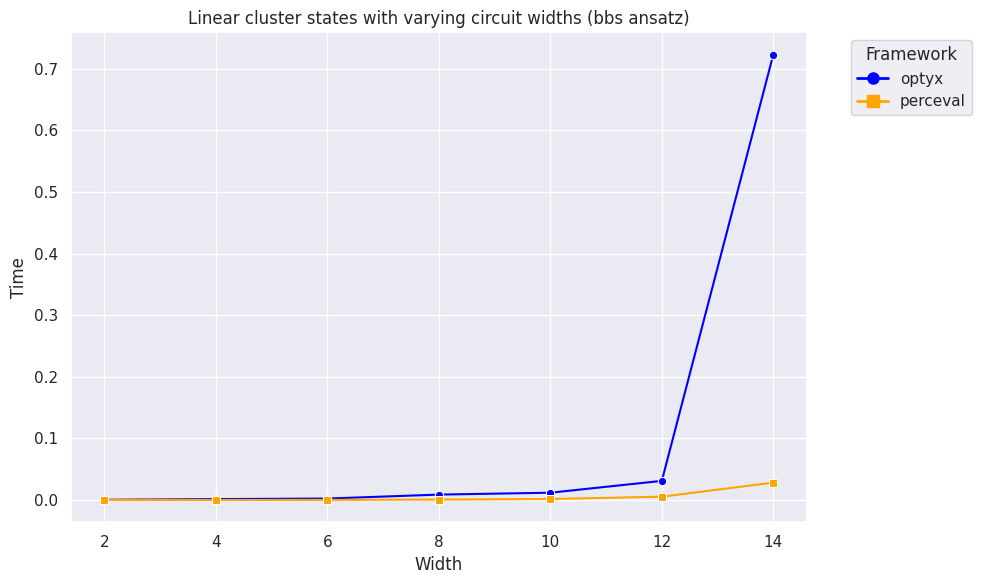

In [62]:
plot("Bosonic product state", "mzi", "Bosonic product states with varying circuit widths (mzi ansatz)", 1)
plot("Bosonic product state", "bbs", "Bosonic product states with varying circuit widths (bbs ansatz)", 1)
plot("GHZ", "mzi", "GHZ states with varying circuit widths (mzi ansatz)", 1)
plot("GHZ", "bbs", "GHZ states with varying circuit widths (bbs ansatz)", 1)
plot("Linear cluster state", "mzi", "Linear cluster states with varying circuit widths (mzi ansatz)", 1)
plot("Linear cluster state", "bbs", "Linear cluster states with varying circuit widths (bbs ansatz)", 1)

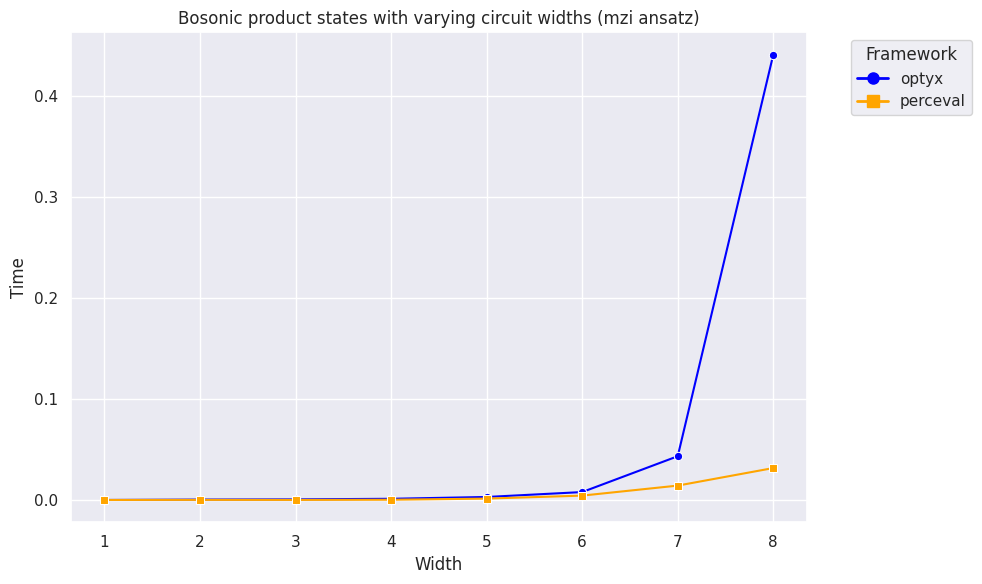

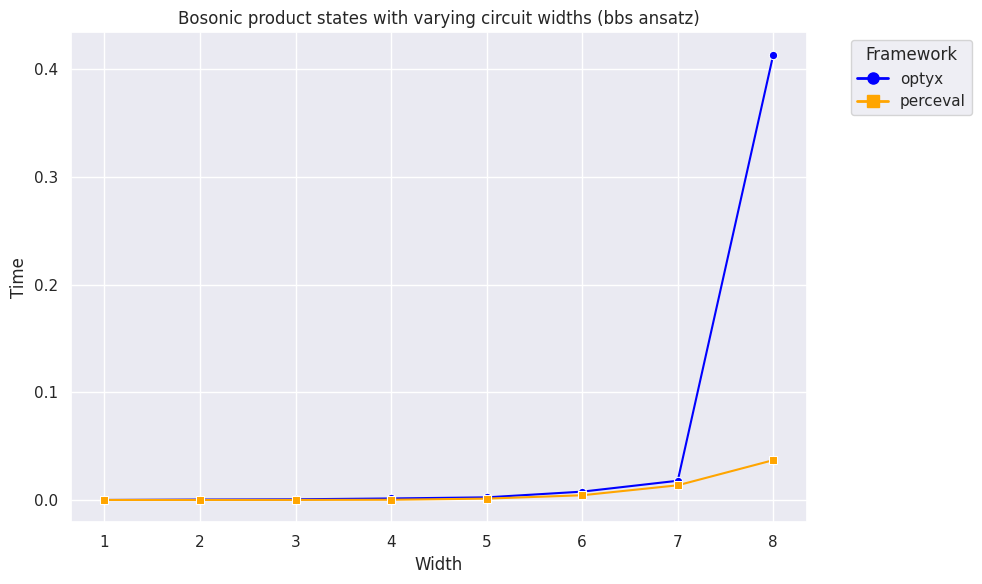

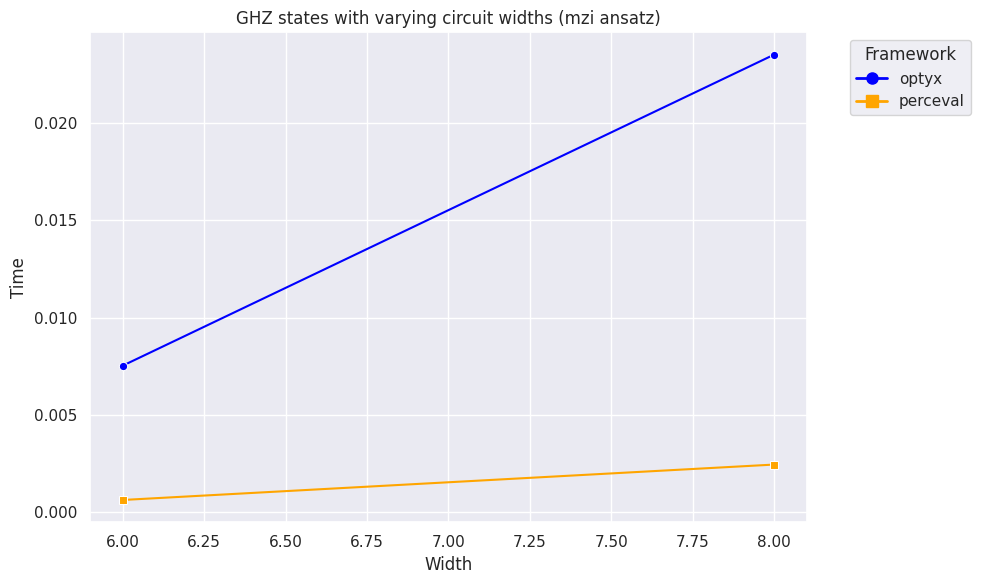

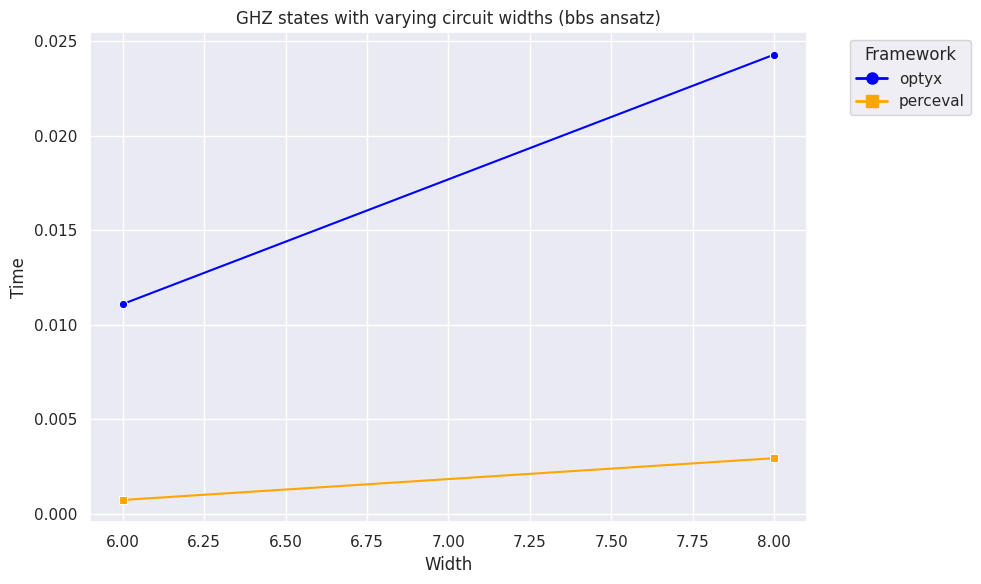

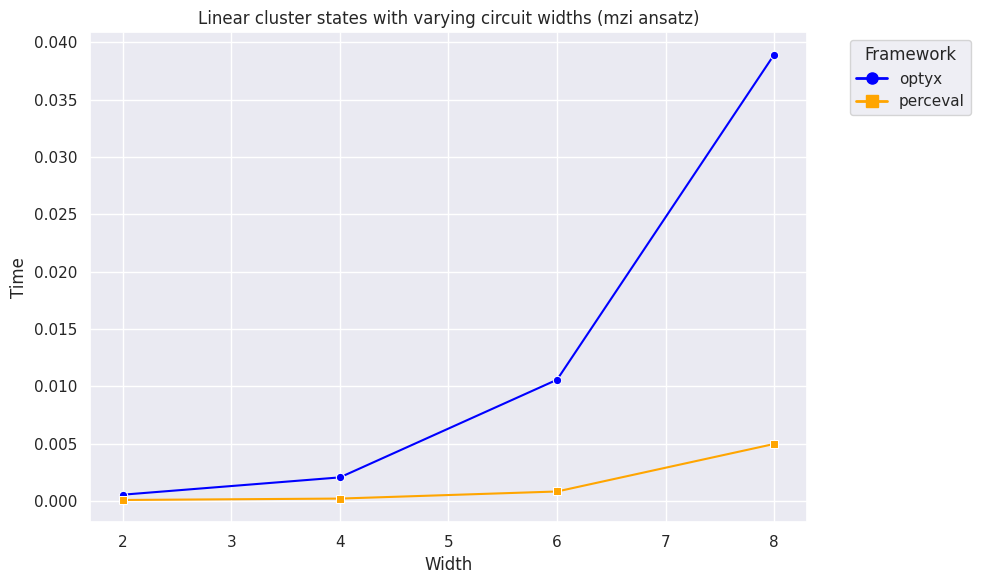

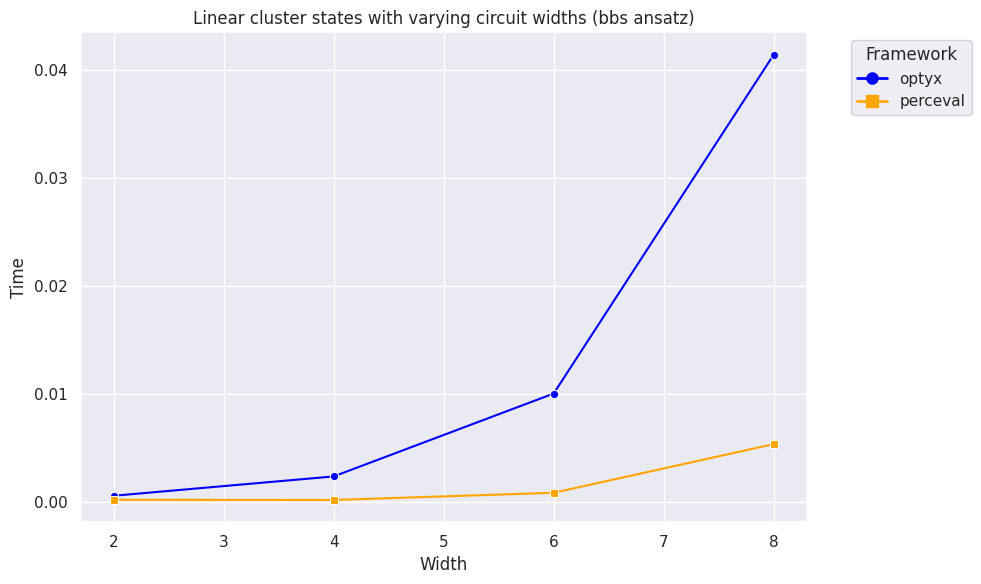

In [64]:
plot("Bosonic product state", "mzi", "Bosonic product states with varying circuit widths (mzi ansatz)", 3)
plot("Bosonic product state", "bbs", "Bosonic product states with varying circuit widths (bbs ansatz)", 3)
plot("GHZ", "mzi", "GHZ states with varying circuit widths (mzi ansatz)", 3)
plot("GHZ", "bbs", "GHZ states with varying circuit widths (bbs ansatz)", 3)
plot("Linear cluster state", "mzi", "Linear cluster states with varying circuit widths (mzi ansatz)", 3)
plot("Linear cluster state", "bbs", "Linear cluster states with varying circuit widths (bbs ansatz)", 3)